In [12]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import seaborn as sns

In [13]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM


In [14]:
df_sales = pd.read_csv('train.csv')

In [15]:
df_sales.shape

(913000, 4)

In [16]:
df_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [17]:
df_sales['date'] = pd.to_datetime(df_sales['date'])
#represent month in date field as its first day
df_sales['date'] = df_sales['date'].dt.year.astype('str') + '-' + df_sales['date'].dt.month.astype('str') + '-01'
df_sales['date'] = pd.to_datetime(df_sales['date'])
#groupby date and sum the sales
df_sales = df_sales.groupby('date').sales.sum().reset_index()

In [18]:
df_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


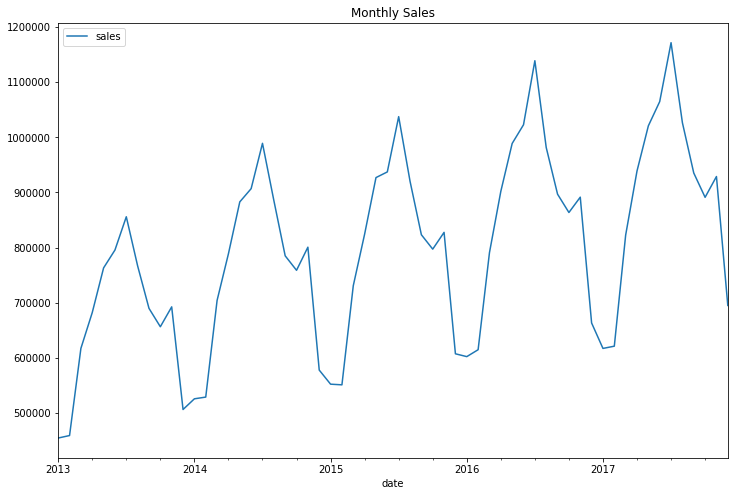

In [61]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
df_sales.plot(x='date',y='sales',ax=ax)
plt.title("Monthly Sales")
plt.show()

In [20]:
#create a new dataframe to model the difference
df_diff = df_sales.copy()

In [21]:
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['sales'].shift(1)

In [22]:
df_diff.head()

,date,sales,prev_sales
0,2013-01-01,454904,NaN
1,2013-02-01,459417,454904.0
2,2013-03-01,617382,459417.0
3,2013-04-01,682274,617382.0
4,2013-05-01,763242,682274.0


In [23]:
#drop the null values and calculate the difference
df_diff = df_diff.dropna()

In [24]:
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])

In [25]:
df_diff.head(20)

,date,sales,prev_sales,diff
1,2013-02-01,459417,454904.0,4513.0
2,2013-03-01,617382,459417.0,157965.0
3,2013-04-01,682274,617382.0,64892.0
4,2013-05-01,763242,682274.0,80968.0
5,2013-06-01,795597,763242.0,32355.0
6,2013-07-01,855922,795597.0,60325.0
7,2013-08-01,766761,855922.0,-89161.0
8,2013-09-01,689907,766761.0,-76854.0
9,2013-10-01,656587,689907.0,-33320.0
10,2013-11-01,692643,656587.0,36056.0


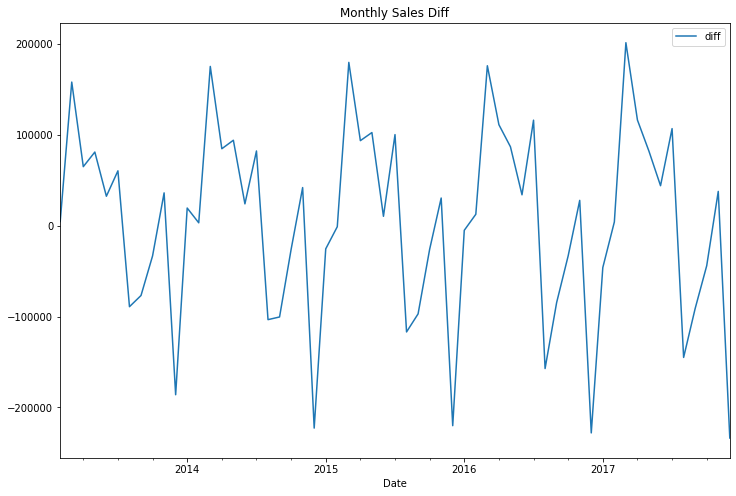

In [65]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
df_diff.plot(x='date',y='diff',ax=ax)
plt.xlabel("Date")
plt.title("Monthly Sales Diff")
plt.show()

In [26]:
#create new dataframe from transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)

In [27]:
df_supervised.head(20)

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
1,2013-02-01,459417,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-03-01,617382,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-04-01,682274,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-05-01,763242,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2013-06-01,795597,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2013-07-01,855922,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2013-08-01,766761,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN
8,2013-09-01,689907,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN
9,2013-10-01,656587,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN
10,2013-11-01,692643,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN


In [28]:
df_supervised.tail(6)

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
54,2017-07-01,1171393,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0,116054.0
55,2017-08-01,1026403,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0
56,2017-09-01,935263,-91140.0,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0
57,2017-10-01,891160,-44103.0,-91140.0,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0
58,2017-11-01,928837,37677.0,-44103.0,-91140.0,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0
59,2017-12-01,695170,-233667.0,37677.0,-44103.0,-91140.0,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0


In [29]:
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [30]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.02893426930900389


In [31]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.4406493613886946


In [32]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.9795722233296558


In [33]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['sales','date'],axis=1)
#split train and test set
train_set, test_set = df_model[0:-6].values, df_model[-6:].values
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 13 columns):
diff      47 non-null float64
lag_1     47 non-null float64
lag_2     47 non-null float64
lag_3     47 non-null float64
lag_4     47 non-null float64
lag_5     47 non-null float64
lag_6     47 non-null float64
lag_7     47 non-null float64
lag_8     47 non-null float64
lag_9     47 non-null float64
lag_10    47 non-null float64
lag_11    47 non-null float64
lag_12    47 non-null float64
dtypes: float64(13)
memory usage: 4.9 KB


In [34]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)

# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [35]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [36]:
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [37]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/100
41/41 [==============================] - 3s 74ms/step - loss: 0.2124
Epoch 2/100
41/41 [==============================] - 0s 5ms/step - loss: 0.1740
Epoch 3/100
41/41 [==============================] - 0s 5ms/step - loss: 0.1497
Epoch 4/100
41/41 [==============================] - 0s 5ms/step - loss: 0.1339
Epoch 5/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1232
Epoch 6/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1150
Epoch 7/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1081
Epoch 8/100
41/41 [==============================] - 0s 4ms/step - loss: 0.1016
Epoch 9/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0954
Epoch 10/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0895
Epoch 11/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0838
Epoch 12/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0784
Epoch 13/100
41/41 [================

In [38]:
y_pred = model.predict(X_test,batch_size=1)

In [39]:
y_pred 

array([[ 0.64185476],
       [-0.5335612 ],
       [-0.35131484],
       [-0.02517025],
       [ 0.23216555],
       [-1.0454019 ]], dtype=float32)

In [40]:
y_test

array([[ 0.55964922],
       [-0.61313659],
       [-0.36228353],
       [-0.14316792],
       [ 0.23779333],
       [-1.02622661]])

In [41]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

In [42]:
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

[[ 0.64185476  0.26695937  0.44344626  0.60355899  1.10628178  0.13866328
  -0.10745675 -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352
   0.68397168]]
[[-0.53356123  0.55964922  0.26695937  0.44344626  0.68877355  1.10628178
   0.13866328 -0.12204966 -1.02635392  0.24535439 -0.05787474 -0.31370458
  -0.67437352]]
[[-0.35131484 -0.61313659  0.55964922  0.26695937  0.52015228  0.68877355
   1.10628178  0.12731349 -0.12204966 -1.02635392  0.24535439 -0.05787474
  -0.31370458]]
[[-0.02517025 -0.36228353 -0.61313659  0.55964922  0.33428672  0.52015228
   0.68877355  1.10768225  0.12731349 -0.12204966 -1.02635392  0.24535439
  -0.05787474]]
[[ 0.23216555 -0.14316792 -0.36228353 -0.61313659  0.64253037  0.33428672
   0.52015228  0.68467253  1.10768225  0.12731349 -0.12204966 -1.02635392
   0.24535439]]
[[-1.04540193  0.23779333 -0.14316792 -0.36228353 -0.59257833  0.64253037
   0.33428672  0.51382935  0.68467253  1.10768225  0.12731349 -0.12204966
  -1.02635392]]


In [43]:
pred_test_set[0]

array([[ 0.64185476,  0.26695937,  0.44344626,  0.60355899,  1.10628178,
         0.13866328, -0.10745675, -1.02635392,  0.24535439, -0.05787474,
        -0.31370458, -0.67437352,  0.68397168]])

In [44]:
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [45]:
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [46]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_sales[-7:].date)
act_sales = list(df_sales[-7:].sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [47]:
df_result

,date,pred_value
0,2017-07-01,1189039
1,2017-08-01,1043485
2,2017-09-01,937617
3,2017-10-01,916490
4,2017-11-01,927628
5,2017-12-01,691053


In [48]:
df_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


In [49]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(df_sales,df_result,on='date',how='left')

In [50]:
df_sales_pred

,date,sales,pred_value
0,2013-01-01,454904,NaN
1,2013-02-01,459417,NaN
2,2013-03-01,617382,NaN
3,2013-04-01,682274,NaN
4,2013-05-01,763242,NaN
5,2013-06-01,795597,NaN
6,2013-07-01,855922,NaN
7,2013-08-01,766761,NaN
8,2013-09-01,689907,NaN
9,2013-10-01,656587,NaN


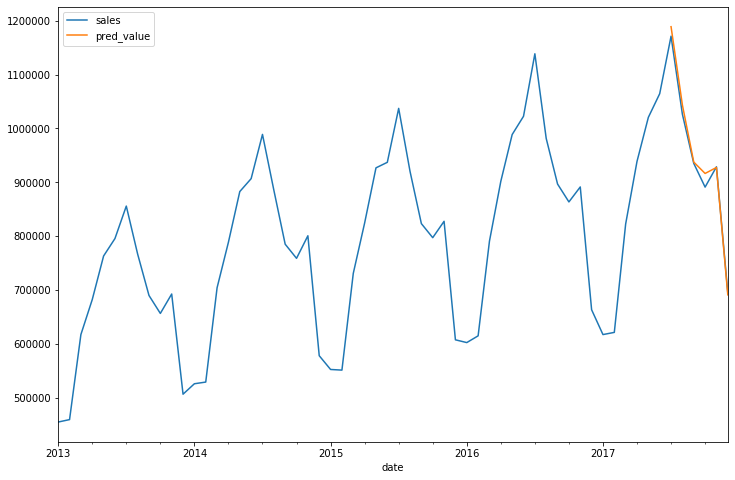

In [69]:
fig, ax = plt.subplots(figsize=(12,8))
df_sales_pred.plot(x='date',y='sales',ax=ax)
df_sales_pred.plot(x='date',y='pred_value',ax=ax)
#plt.legend(["Low-Value","Mid-Value","High-Value"],loc='lower left',frameon=False)